# Trabalho Prático 4

## Grupo 04 - Renato Garcia (A101987) & Bernardo Moniz (A102497)

## Problema 1
### Enunciado

No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

    

A componente discreta do autómato contém os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  não existe qualquer força de travagem; no modo `Stopping` aplica-se a força de travagem alta; no modo `Blocked` as rodas estão bloqueadas em relação ao corpo mas o veículo  desloca-se; no modo `Stopped` o veículo está imobilizado.

A componente contínua  do autómato usa variáveis contínuas $\,V,v\,$ para descrever a  `velocidade do corpo`  do veículo em relação ao solo e a `velocidade linear das rodas` também em relação ao solo.  Assume-se que o sistema de travagem exerce uma força de atrito  nos travões proporcional à diferença das duas velocidades.  A dinâmica contínua está descrita  abaixo no bloco Equaçoes de Fluxo.


a. Defina um autómato híbrido que descreva a dinâmica do sistema segundo as notas abaixo indicadas e com os “switchs” por si escolhidos. 
    Os “switchs” (“jumps”) são uma  componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condições de modo a que o sistema tenha um comportamento desejável: imobilize-se depressa e não “derrape” muito.

b. Modele em lógica temporal linear LT  propriedades que caracterizam o comportamento desejável do sistema. Nomeadamente 
    
i. ”o veículo imobiliza-se completamente em menos de $t$ segundos” 
    
ii. “a velocidade $V$ diminui sempre com o tempo”.

c. Construa o FOTS que que descreve a discretização do  modelo  que definiu em a. e codifique em SMT’s

d. Codifique a verificação das propriedades temporais que definiu em b.

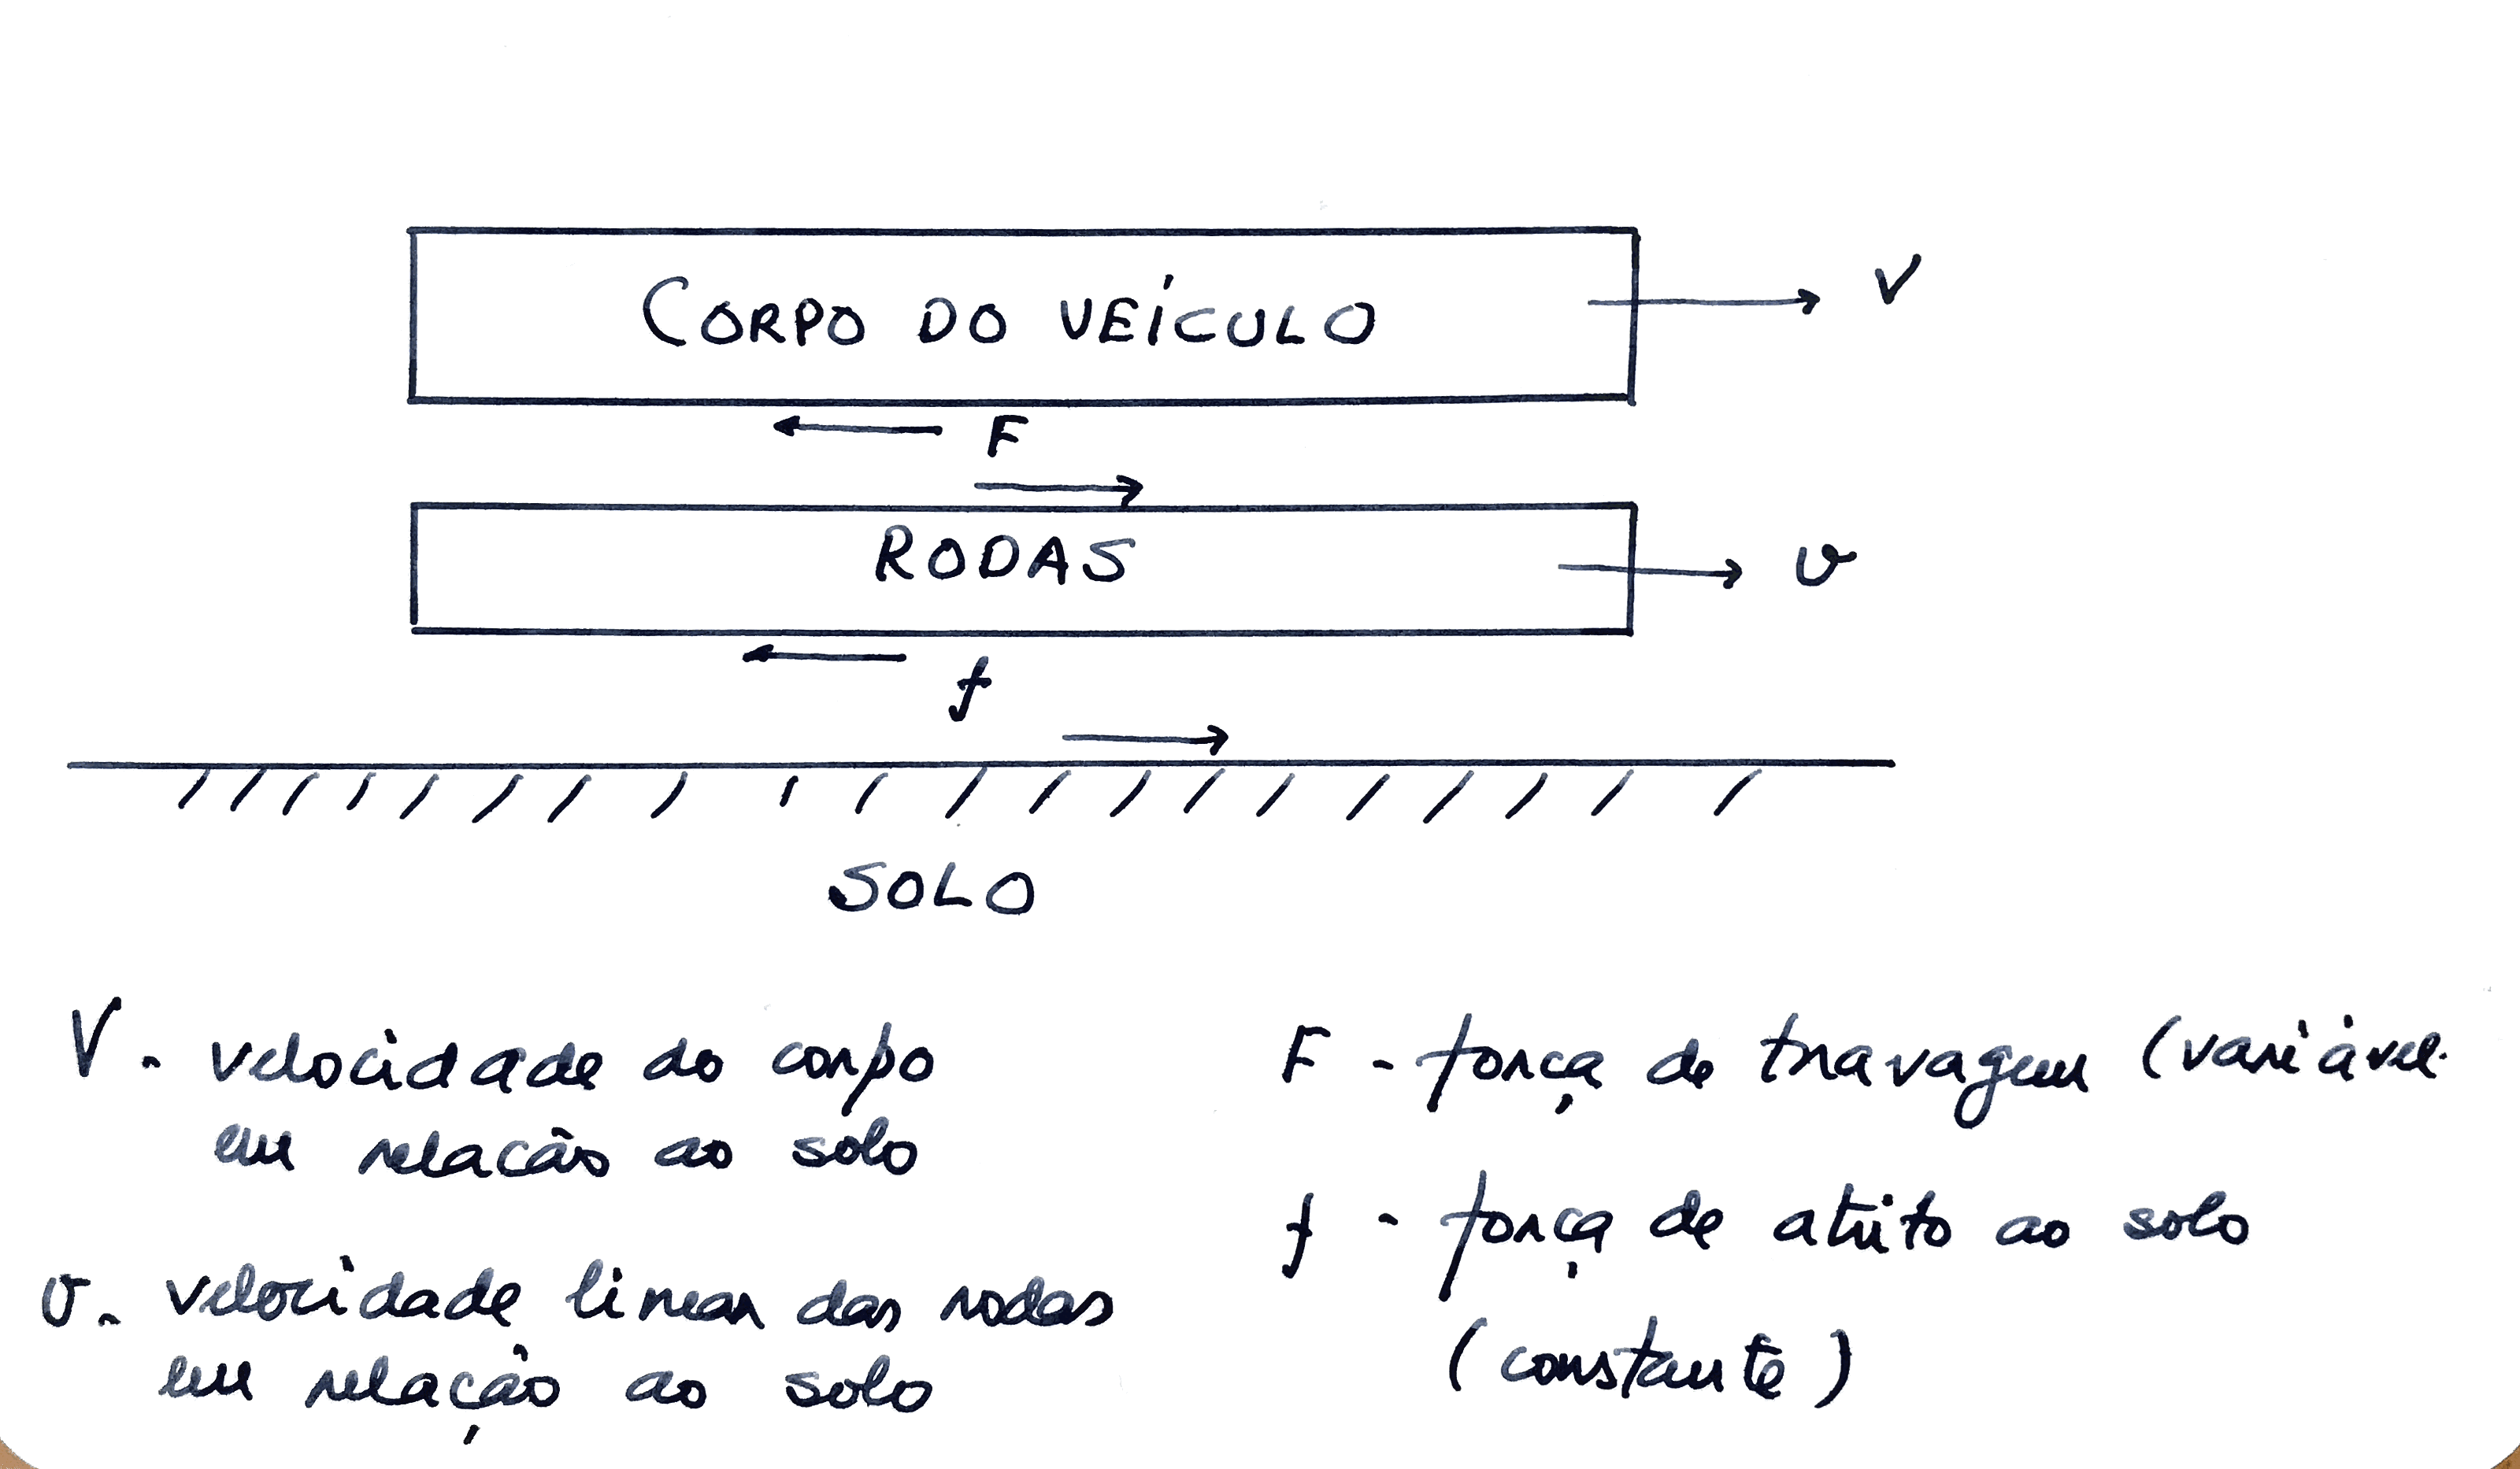

**Equações de Fluxo**

1. Durante  a travagem não existe qualquer  força no sistema excepto as forças de atrito. Quando uma superfície se desloca em relação à outra, a força de atrito  é proporcional à força de compressão entre elas. 

2. No contacto rodas/solo o atrito é constante porque a força de compressão é o peso; tem-se $f = a\cdot P$ sendo  $a$ a constante de atrito e $P$ o peso. Ambos são fixos e independentes do modo.

3. No contacto corpo/rodas,  a força de compressão é a força de travagem que aqui se assume como proporcional à diferença de velocidades  $F =  c\cdot (V-v)$.  A  constante de proporcionalidade $c$ depende do modo: é elevada no modo `Stopping` e baixa nos outros.

4. Existe um atrito no contacto corpo/ar  que é aproximado por uma constante positiva $\,b$.

5. As equações que traduzem a dinâmica  do sistema são, em todos os modo excepto `Blocked`,
$$\begin{array}{rcl} \dot{V} & = & - c\cdot(V-v) - b\\ \dot{v} & = & -a\cdot P  + c\cdot(V-v) \end{array}$$   

<div style="margin-left: 3em;">
e, no modo <code>Blocked</code>, a dinâmica do sistema é regida por
</div>

$$(V = v) \;\land\; (\,\dot{V}\,=\, -a\cdot P - b\,)$$


6. Tanto no modo `Blocked`  como no modo `Free`  existe um “timer” que impede que se permaneça nesses modo mais do que $\,\tau$ segundos. Os **jumps**$\,(V,v,t,V',v',t')$ com origem nesses modos devem forçar esta condição.

7. No instante inicial assume-se $\,V = v\,=\,V_0$  ,  em que a velocidade $V_0$ é o “input” do problema.

### Resolução

In [1]:
from z3 import *
import matplotlib.pyplot as plt
import pygraphviz as pgv
from IPython.display import Image

#### Função para desenhar o autómato híbrido

In [2]:
def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

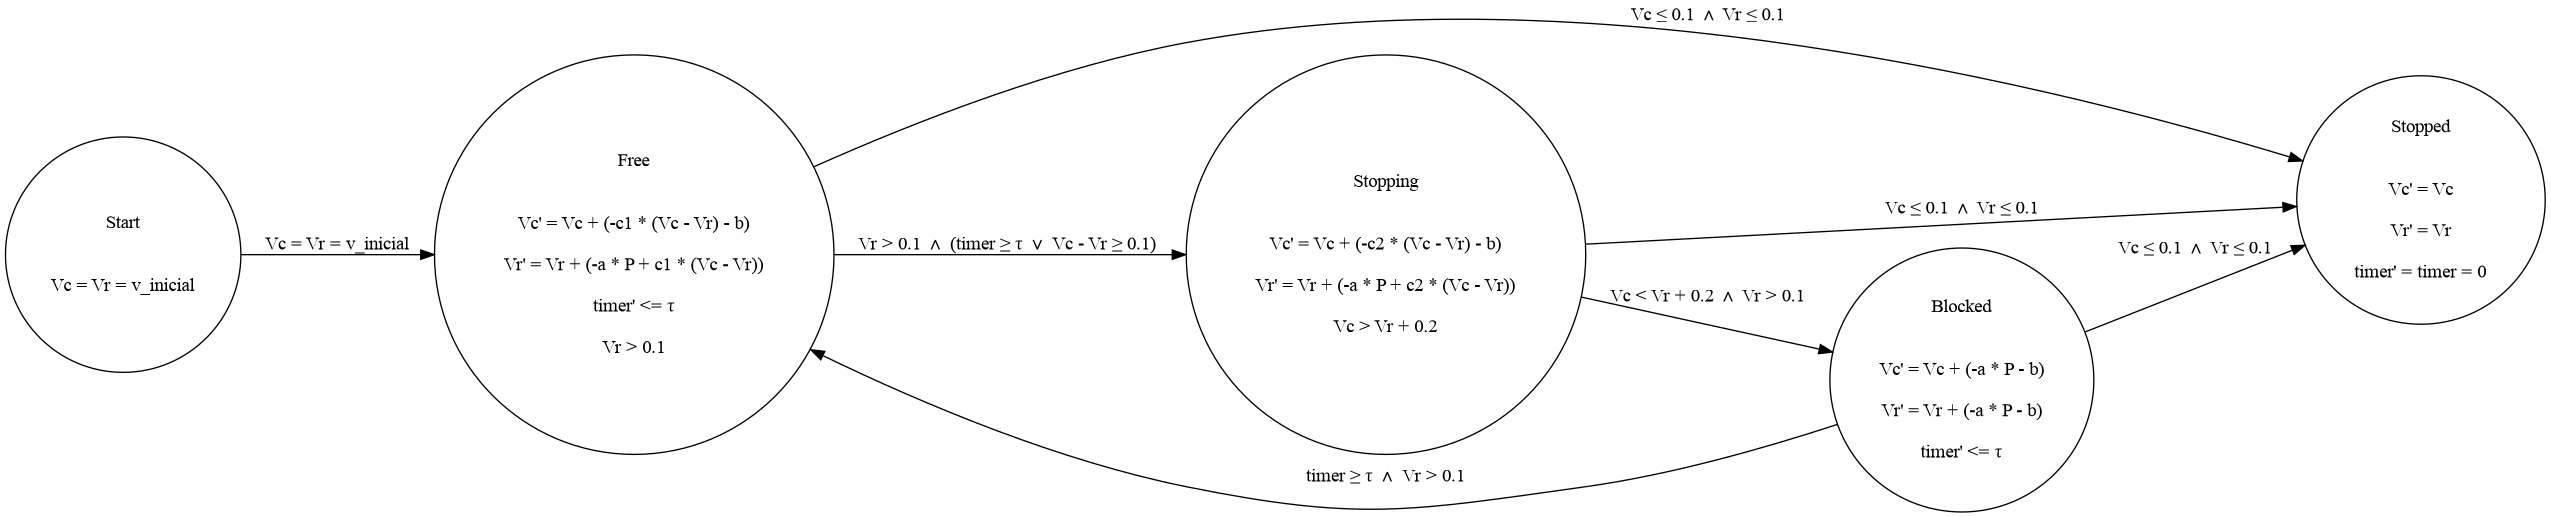

In [3]:
ABS = """digraph{
    rankdir=LR;
    Start [shape= circle, label="Start\n\n\nVc = Vr = v_inicial"];
    Free [shape = circle, label="Free\n\n\nVc' = Vc + (-c1 * (Vc - Vr) - b)\n\nVr' = Vr + (-a * P + c1 * (Vc - Vr))\n\ntimer' <= τ\n\nVr > 0.1"];
    Stopping [shape = circle, label="Stopping\n\n\nVc' = Vc + (-c2 * (Vc - Vr) - b)\n\nVr' = Vr + (-a * P + c2 * (Vc - Vr))\n\nVc > Vr + 0.2"];
    Blocked [shape = circle, label="Blocked\n\n\nVc' = Vc + (-a * P - b)\n\nVr' = Vr + (-a * P - b)\n\ntimer' <= τ"];
    Stopped [shape = circle, label="Stopped\n\n\nVc' = Vc\n\nVr' = Vr\n\ntimer' = timer = 0"];

    Start -> Free[label="Vc = Vr = v_inicial"];
    Free -> Stopping[label="Vr > 0.1 ∧ (timer ≥ τ ∨ Vc - Vr ≥ 0.1) "];
    Stopping -> Blocked[label="Vc < Vr + 0.2 ∧ Vr > 0.1"];
    Stopping -> Stopped[label="Vc ≤ 0.1 ∧ Vr ≤ 0.1"];
    Blocked -> Free [label="timer ≥ τ ∧ Vr > 0.1"];
    Blocked -> Stopped[label="Vc ≤ 0.1 ∧ Vr ≤ 0.1"];
    Free -> Stopped[label="Vc ≤ 0.1 ∧ Vr ≤ 0.1"];
}"""

draw(ABS)

#### Constantes e variaveis do sistema

##### Constantes
- $a$ - constante de atrito rodas/solo
- $b$ - constante de atrito corpo/ar
- $c1$ - constante de proporcionalidade menor para o modo `Free`
- $c2$ - constante de proporcionalidade maior para o modo `Stopping`
- $P$ - peso em kilogramas do veículo
- $tau$ ($\,\tau$) - tempo em segundos que o veículo pode permanecer nos modos `Blocked` e `Free`
- $intervalo$ - diferença de tempo entre cada iteração do sistema, $t'- t$
- $v_{inicial}$ - velocidade inicial do veículo 
- $time$ - tempo máximo em segundos até o veículo imobilizar-se

##### Variáveis racionais 
- $Vc$ - velocidade do corpo em relação ao solo
- $Vr$ - velocidade linear das rodas em relação ao solo
- $t$ - tempo 
- $timer$ - tempo que o veículo permanece em um modo `Blocked` ou `Free`

##### Variáveis discretas
- $m$ - modo

##### Função declare(i) 
- Função que declara as variáveis do sistema

In [4]:
Mode, (START, STOPPING, STOPPED, BLOCKED, FREE) = EnumSort('Mode', ('START','STOPPING','STOPPED','BLOCKED','FREE'))

def declare(i):
    state = {}
    state['m']  = Const('m'+str(i),Mode)
    state['Vc'] = Real('Vc'+str(i))
    state['Vr'] = Real('Vr'+str(i))
    state['t']  = Real('t' +str(i))
    state['timer'] = Real('timer'+str(i))
    return state

##### Escolha de valores para as constantes

In [5]:
a = 0.01
b = 0.5
c1 = 0.5
c2 = 10
P = 1200
tau = 0.1
intervalo = 0.1
time = 3
v_inicial = 25

##### Função init(s, v_input)
- Função que inicializa as variáveis do sistema

In [6]:
def init(s, v_input): 
  return And(s['t'] == 0, 
             s['m'] == START, 
             s['Vr'] == v_input,
             s['Vc'] == v_input
            )

##### Função trans(s, p)
- Função que define as transições do sistema

In [7]:
def trans(s, p): 
  # Untimed
  
  start_free       = And( 
                          s['t'] == p['t'], 
                          s['Vc'] == p['Vc'], 
                          s['Vr'] == p['Vr'],
                          s['m'] == START, 
                          p['m'] == FREE,
                          s['timer'] == 0,
                          p['timer'] == 0 
                        )
  
  free_stopped    =  And( 
                          s['t'] == p['t'],   
                          s['m'] == FREE,       
                          p['m'] == STOPPED, 
                          s['Vc'] <= 0.1,
                          s['Vr'] <= 0.1,
                          p['Vc'] == 0,
                          p['Vr'] == 0,
                          p['timer'] == 0
                        )
  
  free_stopping    = And( 
                          s['t'] == p['t'], 
                          s['Vc'] == p['Vc'],
                          s['Vr'] == p['Vr'], 
                          s['m'] == FREE, 
                          p['m'] == STOPPING,  
                          p['timer'] == 0,
                          s['Vr'] > 0.1,
                          Or(
                            s['timer'] >= tau,
                            s['Vc'] - s['Vr'] >= 0.1
                          )
                        )
  
  stopping_blocked = And( 
                          s['t'] == p['t'], 
                          s['Vc'] == p['Vc'], 
                          s['Vr'] == p['Vr'], 
                          s['m'] == STOPPING, 
                          p['m'] == BLOCKED, 
                          s['Vc'] < s['Vr'] + 0.2,
                          s['timer'] == 0,
                          p['timer'] == 0,
                          s['Vr'] > 0.1
                        )
  
  blocked_free     = And( 
                          s['t'] == p['t'], 
                          s['Vc'] == p['Vc'], 
                          s['Vr'] == p['Vr'], 
                          s['m'] == BLOCKED, 
                          p['m'] == FREE, 
                          s['timer'] >= tau, 
                          p['timer'] == 0,
                          s['Vr'] > 0.1
                        )
  
  blocked_stopped = And(  
                          s['t'] == p['t'],  
                          s['m'] == BLOCKED, 
                          p['m'] == STOPPED,
                          s['Vc'] <= 0.1,
                          s['Vr'] <= 0.1,
                          p['Vc'] == 0,
                          p['Vr'] == 0,
                          p['timer'] == 0
                        )
  
  stopping_stopped = And( 
                          s['t']  == p['t'],  
                          s['m']  == STOPPING, 
                          p['m']  == STOPPED, 
                          s['Vc'] <= 0.1,
                          s['Vr'] <= 0.1,
                          p['Vc'] == 0,
                          p['Vr'] == 0,
                          p['timer'] == 0
                        )
  
  untimed = Or(start_free, free_stopped, free_stopping, stopping_blocked, blocked_free, blocked_stopped, stopping_stopped)
  
  
  
  # Timed
  
  free_free = And(
                  s['m'] == FREE, 
                  p['m'] == FREE, 
                  p['Vc']   == s['Vc'] +   (-c1 * (s['Vc'] - s['Vr']) -b) * intervalo, 
                  p['Vr']   == s['Vr'] +   (-a * P + c1 * (s['Vc'] - s['Vr'])) * intervalo, 
                  p['t'] == s['t'] + intervalo, 
                  p['timer'] == s['timer'] + intervalo,
                  p['timer'] <= tau,
                  s['Vr'] > 0.1
                )
  
  stopping_stopping = And(
                          s['m'] == STOPPING, 
                          p['m'] == STOPPING, 
                          p['Vc']   == s['Vc'] +   (-c2 * (s['Vc'] - s['Vr']) - b) * intervalo, 
                          p['Vr']   == s['Vr'] +   (-a * P + c2 * (s['Vc'] - s['Vr'])) * intervalo,
                          s['Vc'] > s['Vr'] + 0.2,
                          p['t'] == s['t'] + intervalo,
                          s['timer'] == p['timer']
                        )
  
  blocked_blocked = And(
                        s['m'] == BLOCKED,
                        p['m'] == BLOCKED, 
                        p['Vc']   == s['Vc'] + (-a * P -b) * intervalo, 
                        p['Vr']   == s['Vr'] + (-a * P -b) * intervalo, # mmm s[Vc] = s[Vr]
                        p['t'] == s['t'] + intervalo,
                        p['timer'] == s['timer'] + intervalo,
                        p['timer'] <= tau
                      )
  
  stopped_stopped = And(
                          s['m'] == STOPPED, 
                          p['m'] == STOPPED, 
                          p['t'] == s['t'] + intervalo,
                          s['timer'] == 0,
                          p['timer'] == 0,
                          s['Vr'] == p['Vr'],
                          s['Vc'] == p['Vc']
                        )
  

  timed = Or(free_free, stopping_stopping, blocked_blocked, stopped_stopped)
  
  
  
  return Or(untimed, timed)

##### Função gera_traco
- Função que gera um traço do sistema com k estados

In [8]:
def frac2float(x):
    return float(x.numerator_as_long())/float(x.denominator_as_long())

def gera_traco(declare, init, trans, k):
    T = []
    VV = []
    VR = []
    s = Solver()
    traco = [declare(i) for i in range(k)]

    s.add(init(traco[0], 25))
    
    for i in range(k-1):
        s.add(trans(traco[i], traco[i+1]))
        
    #s.add(traco[k-1]['m'] == STOPPED) Garante que o automóvel se imobiliza
    
    if s.check() == sat:
        m = s.model()
        
        T  = [frac2float(m[traco[i]["t"]] ) for i in range(k)]  
        VV = [frac2float(m[traco[i]["Vc"]]) for i in range(k)]         
        VR = [frac2float(m[traco[i]["Vr"]]) for i in range(k)]
        for i in range(k):
            print("Estado:", i)
            for v in traco[i]:
                
                res = m[traco[i][v]]                
                    
                
                if res.sort() != RealSort():
                    print(v, '=', res)
                else:
                    print(v, '=', float(res.numerator_as_long())/float(res.denominator_as_long()))
            print()
    else:
        print("Não tem solução.")
    plt.plot(T, VV, T, VR)

Estado: 0
m = START
Vc = 25.0
Vr = 25.0
t = 0.0
timer = 0.0

Estado: 1
m = FREE
Vc = 25.0
Vr = 25.0
t = 0.0
timer = 0.0

Estado: 2
m = FREE
Vc = 24.95
Vr = 23.8
t = 0.1
timer = 0.1

Estado: 3
m = STOPPING
Vc = 24.95
Vr = 23.8
t = 0.1
timer = 0.0

Estado: 4
m = STOPPING
Vc = 23.75
Vr = 23.75
t = 0.2
timer = 0.0

Estado: 5
m = BLOCKED
Vc = 23.75
Vr = 23.75
t = 0.2
timer = 0.0

Estado: 6
m = BLOCKED
Vc = 22.5
Vr = 22.5
t = 0.3
timer = 0.1

Estado: 7
m = FREE
Vc = 22.5
Vr = 22.5
t = 0.3
timer = 0.0

Estado: 8
m = FREE
Vc = 22.45
Vr = 21.3
t = 0.4
timer = 0.1

Estado: 9
m = STOPPING
Vc = 22.45
Vr = 21.3
t = 0.4
timer = 0.0

Estado: 10
m = STOPPING
Vc = 21.25
Vr = 21.25
t = 0.5
timer = 0.0

Estado: 11
m = BLOCKED
Vc = 21.25
Vr = 21.25
t = 0.5
timer = 0.0

Estado: 12
m = BLOCKED
Vc = 20.0
Vr = 20.0
t = 0.6
timer = 0.1

Estado: 13
m = FREE
Vc = 20.0
Vr = 20.0
t = 0.6
timer = 0.0

Estado: 14
m = FREE
Vc = 19.95
Vr = 18.8
t = 0.7
timer = 0.1

Estado: 15
m = STOPPING
Vc = 19.95
Vr = 18.8
t = 0.7


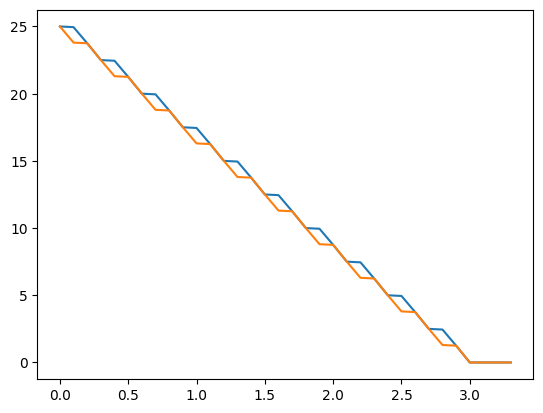

In [9]:
gera_traco(declare, init, trans, 65)

#### Verificação das Propriedades Temporais

i. ”o veículo imobiliza-se completamente em menos de $t$ segundos” 

ii. “a velocidade $V$ diminui sempre com o tempo”

In [10]:
def prop_i(state):
    return Implies(
        state['t'] >= time,
        state['m'] == STOPPED
    )

In [11]:
def prop_ii(curr, prox):
    return Implies(
        curr['t'] < prox['t'],
        curr['Vc'] > prox['Vc']
    )

In [12]:
def testa_prop_i(declare, init, trans, inv, K):
    for k in range(1, K+1):
        s = Solver()
        
        trace = [declare(i) for i in range(k)]
        
        s.add(init(trace[0], v_inicial))
        for i in range(k-1):
            s.add(trans(trace[i],trace[i+1]))
        
        s.add(Not(inv(trace[k-1])))
        
        if s.check() == sat:
            m = s.model()
            for i in range(k):
                for v in trace[i]:
                    print(i,v,'=',m[trace[i][v]])
            return

    print ("Property MAY be valid")

In [13]:
testa_prop_i(declare,init,trans, prop_i, 50)

Property MAY be valid


In [14]:
def testa_prop_ii(declare, init, trans, inv, K):
    for k in range(1, K+1):
        s = Solver()
        
        trace = [declare(i) for i in range(k)]
        
        s.add(init(trace[0], v_inicial))
        aux = []
        for i in range(k-1):
            s.add(trans(trace[i],trace[i+1]))
            aux.append(Not(inv(trace[i],trace[i+1])))
        
        s.add(Or(aux))
        
        if s.check() == sat:
            m = s.model()
            for i in range(k):
                for v in trace[i]:
                    print(i,v,'=',m[trace[i][v]])
            return

    print ("Property MAY be valid")

In [15]:
testa_prop_ii(declare, init, trans, prop_ii, 20)

Property MAY be valid
